In [1]:
pip install kaleido

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 11.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np

In [3]:
path = '/kaggle/input/real-estate-city24/data/2022-10-30/apartments/sale/harju/properties.csv'
data = pd.read_csv(path, index_col=0)
data.columns

Index(['Address', 'District', 'Date', 'Tube', 'Magamistube', 'Vannitube',
       'Üldpind', 'Rõdu', 'Rõdu pind', 'Korrus', 'Korruseid kokku',
       'Omandiõigus', 'Turvasüsteem', 'Hind', 'Energiamärgis', 'Materjal',
       'Ehitusaasta', 'Lift', 'Parkimine', 'Lisaruumid', 'Küte', 'Sanitaar',
       'Pliit', 'Seisukord', 'Lisaväärtused', 'Suve kommunaalid',
       'Talve kommunaalid', 'Side', 'Kinnistu number', 'Krunt',
       'tasuta parkimine', 'Ventilatsioon', 'Katus', 'Lisainfo',
       'Lisanduvad kommunaalid', 'Lisanduvad kommunaalkulud', 'Tagatisraha',
       'Maakleritasu', 'Parkimiskohti', 'tasuline parkimine', 'Piirangud',
       'maakond'],
      dtype='object')

In [4]:
DROP_COLS = ['Omandiõigus','Turvasüsteem','Krunt', 'Vannitube'
             ,'Pliit','Side','Tagatisraha','Kinnistu number'
             ,'Katus','Lisanduvad kommunaalkulud','Lisainfo','Parkimiskohti'
             ,'tasuline parkimine','Piirangud','Maakleritasu','Lisanduvad kommunaalid'
             ,'Lisaväärtused','Lisaruumid','Parkimine','tasuta parkimine','Ventilatsioon','Suve kommunaalid','Talve kommunaalid','District','Address']
df = data.drop(DROP_COLS, axis=1)
df.columns

Index(['Date', 'Tube', 'Magamistube', 'Üldpind', 'Rõdu', 'Rõdu pind', 'Korrus',
       'Korruseid kokku', 'Hind', 'Energiamärgis', 'Materjal', 'Ehitusaasta',
       'Lift', 'Küte', 'Sanitaar', 'Seisukord', 'maakond'],
      dtype='object')

In [5]:
COLUMN_MAPPING = {'Seisukord':'condition','Tube':'rooms','Magamistube':'bedrooms','Üldpind':'area','Korrus':'floor',
                 'Korruseid kokku':'total_floors','Hind':'price','Energiamärgis':'energy_label','Materjal':'house_material',
                 'Ehitusaasta':'year','Küte':'heating','Sanitaar':'sanitary','Lift':'lift','Rõdu':'balcony','Rõdu pind':'balcony_size'}
df.rename(columns=COLUMN_MAPPING, inplace=True)
df.columns

Index(['Date', 'rooms', 'bedrooms', 'area', 'balcony', 'balcony_size', 'floor',
       'total_floors', 'price', 'energy_label', 'house_material', 'year',
       'lift', 'heating', 'sanitary', 'condition', 'maakond'],
      dtype='object')

In [6]:
df['relative_price'] = df['price']/df['area']
df = df[df['relative_price'] >500]
df.drop('relative_price', inplace=True,axis=1)

In [7]:
df.describe()


,rooms,bedrooms,area,balcony_size,floor,total_floors,price,year
count,4322.000000,3636.000000,4335.000000,1540.000000,4156.000000,4273.000000,4.335000e+03,3813.000000
mean,2.621009,1.807756,64.079059,8.748539,3.514196,5.701849,2.176043e+05,1995.288487
std,1.031242,0.832395,42.517733,10.271213,2.873848,3.595023,1.578663e+05,45.106644
min,1.000000,1.000000,4.000000,0.000000,-1.000000,1.000000,1.190000e+04,1219.000000
25%,2.000000,1.000000,44.200000,3.500000,2.000000,3.000000,1.269900e+05,1977.000000
50%,3.000000,2.000000,59.000000,5.000000,3.000000,5.000000,1.850000e+05,2008.000000
75%,3.000000,2.000000,74.250000,10.000000,5.000000,8.000000,2.619900e+05,2022.000000
max,19.000000,6.000000,1728.300000,136.500000,70.000000,30.000000,3.111000e+06,2024.000000


In [8]:
# Dropping rows without the most important data
df = df[~df['price'].isna()]
df = df[~df['area'].isna()]
df = df[~df['floor'].isna()]
# Losing a lot of entries with removing nulls but simply using mean or dropping the column does not make sense
df = df[~df['year'].isnull()]
df = df[~df['rooms'].isnull()]

In [9]:
df

,Date,rooms,bedrooms,area,balcony,balcony_size,floor,total_floors,price,energy_label,house_material,year,lift,heating,sanitary,condition,maakond
0,2022-10-30,3.0,2.0,65.6,rõdu,5.0,7.0,9.0,127500.0,D,paneelmaja,1977.0,jah,keskküte,"dušš,wc ja vannituba eraldi",NaN,harju
1,2022-10-30,2.0,1.0,39.6,NaN,NaN,2.0,4.0,39500.0,energiamärgis määramata,kivimaja,1966.0,NaN,keskküte,dušš,vajab kapitaalremonti,harju
2,2022-10-30,3.0,2.0,80.9,NaN,NaN,1.0,2.0,490000.0,B,NaN,2016.0,NaN,gaasiküte,"saun,wc ja vannituba eraldi",uusehitis,harju
3,2022-10-30,1.0,1.0,41.5,NaN,NaN,7.0,11.0,229000.0,energiamärgis määramata,paneelmaja,1994.0,jah,gaasiküte,"dušš,pesumasin",valmis,harju
4,2022-10-30,2.0,1.0,38.6,NaN,NaN,3.0,5.0,53000.0,E,paneelmaja,1987.0,NaN,keskküte,"dušš,pesumasin",valmis,harju
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4362,2022-10-30,1.0,NaN,53.0,NaN,NaN,6.0,9.0,179900.0,NaN,paneelmaja,2006.0,jah,keskküte,"tsentraalne kanalisatsioon,dušš",valmis,harju
4364,2022-10-30,4.0,3.0,109.9,rõdu,8.0,6.0,7.0,385000.0,NaN,paneelmaja,1994.0,jah,keskküte,"saun,tsentraalne kanalisatsioon,dušš,pesumasin",valmis,harju
4366,2022-10-30,5.0,3.0,115.7,NaN,NaN,5.0,7.0,389000.0,energiamärgis määramata,NaN,1920.0,NaN,NaN,NaN,valmis,harju
4367,2022-10-30,2.0,1.0,51.0,NaN,NaN,4.0,4.0,45000.0,NaN,kivimaja,1976.0,NaN,NaN,"dušš,tsentraalne kanalisatsioon,saun,boiler",valmis,harju


In [10]:
# If not provided, assume no balcony
df['balcony_size'] = df['balcony_size'].fillna(0)
df['balcony'] = df['balcony'].fillna(0)

def check_values(col1, col2):
    """Simple function to check if boths inputs are 0."""
    response = 1 if col1!=0 or col2!=0 else 0
    return(response)

# Apply the created function for each row to see if balcony exists.    
df['flag_balcony'] = df.apply(lambda x: check_values(x.balcony_size, x.balcony), axis=1)
df['flag_lift'] = (~df['lift'].isna()).astype(int)
df.drop(['lift','balcony_size','balcony'], axis=1, inplace=True)

<AxesSubplot:>

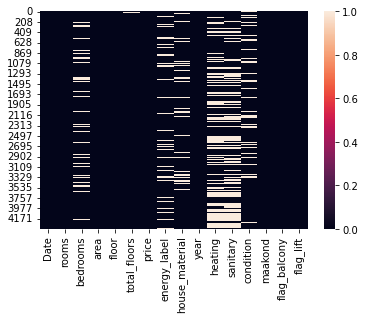

In [11]:
sns.heatmap(df.isnull())

In [12]:
df['energy_label'].unique()

array(['D', 'energiamärgis määramata', 'B', 'E', 'C', 'A', nan, 'F', 'H',
       'G', 'A,A'], dtype=object)

In [13]:
df['sanitary'].unique()[0:15]

array(['dušš,wc ja vannituba eraldi', 'dušš',
       'saun,wc ja vannituba eraldi', 'dušš,pesumasin',
       'wc ja vannituba eraldi', 'vann,pesumasin,dušš', nan,
       'pesumasin,dušš', 'tsentraalne kanalisatsioon,dušš',
       'dušš,pesumasin,boiler,wc ja vannituba eraldi', 'dušš,boiler',
       'pesumasin,wc ja vannituba eraldi,tsentraalne kanalisatsioon,dušš,vann',
       'wc ja vannituba eraldi,vann',
       'dušš,wc ja vannituba eraldi,vann,pesumasin',
       'dušš,wc ja vannituba eraldi,vann'], dtype=object)

In [14]:
df['heating'].unique()[0:15]

array(['keskküte', 'gaasiküte', 'keskküte,põrandaküte', nan,
       'põrandaküte,keskküte', 'keskküte,kamin', 'põrandaküte',
       'kamin,õhksoojuspump', 'gaasiküte,põrandaküte',
       'keskküte,põrandaküte,õhksoojuspump', 'gaasiküte,kamin',
       'keskküte,gaasiküte', 'elektriküte,õhksoojuspump',
       'põrandaküte,gaasiküte', 'keskküte,maaküte'], dtype=object)

In [15]:
# In order to preserve as much data as possible, filling NAs. Useful for feature engineering later.
df['house_material'] = df['house_material'].fillna('Unknown')
df['heating'] = df['heating'].fillna('Unknown')
df['condition'] = df['condition'].fillna('Unknown')
df['sanitary'] = df['sanitary'].fillna('Unknown')
df['energy_label'] = df['energy_label'].fillna('energiamärgis määramata')
df = df.replace("A,A","A")

In [16]:
#Create dummies for most important items
df['flag_shower'] = df['sanitary'].apply(lambda x: int('dušš' in x.strip().lower()))
df['flag_bath'] = df['sanitary'].apply(lambda x: int('vann' in x.strip().lower()))
df['flag_sauna'] = df['sanitary'].apply(lambda x: int('saun' in x.strip().lower()))
df['flag_generalheat'] = df['heating'].apply(lambda x: int('keskküte' in x.strip().lower()))
df['flag_floorheat'] = df['heating'].apply(lambda x: int('põrandaküte' in x.strip().lower()))
df['flag_gasheat'] = df['heating'].apply(lambda x: int('gaasiküte' in x.strip().lower()))
df['flag_electricalheat'] = df['heating'].apply(lambda x: int('õhksoojuspump' in x.strip().lower()))
df.drop('heating', axis=1, inplace=True)
df.drop('sanitary', axis=1, inplace=True)

In [17]:
df = df[df['bedrooms']!=6]
df = df[df['rooms']<9]
df = df[df['floor']<=30.0]

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3648 entries, 0 to 4368
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 3648 non-null   object 
 1   rooms                3648 non-null   float64
 2   bedrooms             3120 non-null   float64
 3   area                 3648 non-null   float64
 4   floor                3648 non-null   float64
 5   total_floors         3618 non-null   float64
 6   price                3648 non-null   float64
 7   energy_label         3648 non-null   object 
 8   house_material       3648 non-null   object 
 9   year                 3648 non-null   float64
 10  condition            3648 non-null   object 
 11  maakond              3648 non-null   object 
 12  flag_balcony         3648 non-null   int64  
 13  flag_lift            3648 non-null   int64  
 14  flag_shower          3648 non-null   int64  
 15  flag_bath            3648 non-null   i

In [19]:
# Imputing with means based on most correlated features
df['total_floors'] = df['total_floors'].fillna(df.groupby('floor')['total_floors'].transform('mean').map(int))
df['bedrooms'] = df['bedrooms'].fillna(df.groupby('rooms')['bedrooms'].transform('mean').map(int))

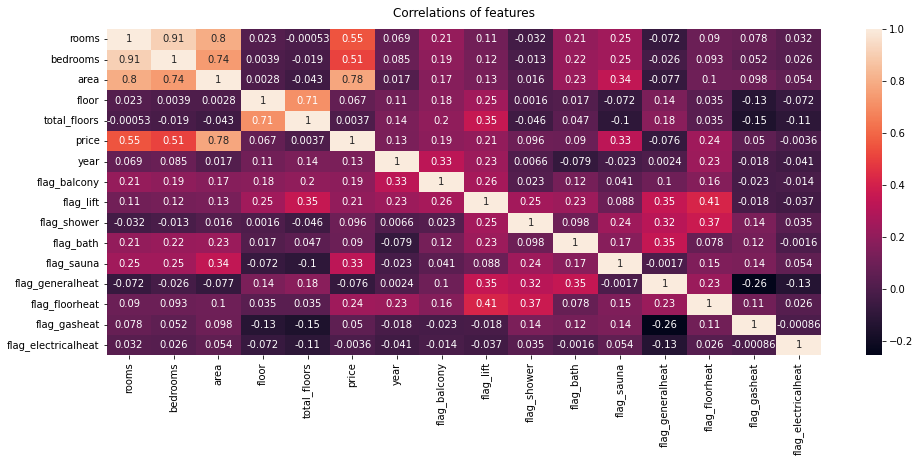

In [20]:
plt.figure(figsize=(16, 6))
correlations = sns.heatmap(df.corr(), annot=True)
correlations.set_title('Correlations of features', fontdict={'fontsize':12}, pad=12);

In [21]:
df['house_material'].unique()[0:25]

array(['paneelmaja', 'kivimaja', 'Unknown', 'paneelmaja,kivimaja',
       'puitmaja', 'betoonmaja', 'plokkmaja', 'betoonmaja,plokkmaja',
       'kivimaja,plokkmaja', 'betoonmaja,kivimaja',
       'plokkmaja,paneelmaja', 'kivimaja,paneelmaja',
       'betoonmaja,paneelmaja,kivimaja', 'palk-kivimaja', 'palkmaja',
       'plokkmaja,kivimaja', 'paneelmaja,kivimaja,betoonmaja',
       'betoonmaja,paneelmaja', 'kivimaja,betoonmaja',
       'paneelmaja,plokkmaja,kivimaja', 'paneelmaja,betoonmaja',
       'puitmaja,palk-kivimaja', 'kivimaja,betoonmaja,paneelmaja',
       'betoonmaja,kivimaja,plokkmaja', 'plokkmaja,betoonmaja'],
      dtype=object)

In [22]:
df['flag_brick'] = df['house_material'].apply(lambda x: int('plokkmaja' in x.strip().lower()))
df['flag_panel'] = df['house_material'].apply(lambda x: int('paneelmaja' in x.strip().lower()))
df['flag_beton'] = df['house_material'].apply(lambda x: int('betoonmaja' in x.strip().lower()))
df['flag_stone'] = df['house_material'].apply(lambda x: int('kivimaja' in x.strip().lower()))
df['flag_wood'] = df['house_material'].apply(lambda x: int('puitmaja' in x.strip().lower()))
df.drop('house_material', axis=1, inplace=True)

In [23]:
df['condition'].unique()[0:25]

array(['Unknown', 'vajab kapitaalremonti', 'uusehitis', 'valmis',
       'renoveeritud', 'san remont tehtud', 'uusehitis,uus viimistlus',
       'uus viimistlus', 'renoveeritud,valmis', 'uusehitis,valmis',
       'vajab renoveerimist,vajab kapitaalremonti',
       'uus viimistlus,uusehitis', 'vajab renoveerimist',
       'uus viimistlus,uusehitis,valmis', 'valmis,renoveeritud',
       'uus viimistlus,valmis', 'valmis,uusehitis',
       'uus viimistlus,renoveeritud,uusehitis,valmis',
       'san remont tehtud,vajab renoveerimist,valmis,renoveeritud',
       'uus viimistlus,valmis,renoveeritud',
       'uusehitis,valmis,renoveeritud,uus viimistlus',
       'san remont tehtud,renoveeritud,uus viimistlus,valmis',
       'valmis,vajab renoveerimist', 'uus viimistlus,renoveeritud',
       'uus viimistlus,uusehitis,valmis,renoveeritud'], dtype=object)

In [24]:
df['flag_newbuilding'] = df['condition'].apply(lambda x: int('uusehitis' in x.strip().lower()))
df['flag_indevelopment'] = df['condition'].apply(lambda x: int('valmimisjärgus' in x.strip().lower()))
df['flag_renovated'] = df['condition'].apply(lambda x: int('renoveeritud' in x.strip().lower()))
df['flag_needsrenovation'] = df['condition'].apply(lambda x: int('vajab renoveerimist' in x.strip().lower()))
df.drop('condition', axis=1, inplace=True)

In [25]:
summary = df.describe()
for col in summary:
    if col[0:4]=='flag':
        print("There are "+str(round(summary[col][1]*summary[col][0]))+" entries for "+col)

There are 2110 entries for flag_balcony
There are 1406 entries for flag_lift
There are 1790 entries for flag_shower
There are 1427 entries for flag_bath
There are 261 entries for flag_sauna
There are 1968 entries for flag_generalheat
There are 1000 entries for flag_floorheat
There are 319 entries for flag_gasheat
There are 70 entries for flag_electricalheat
There are 41 entries for flag_brick
There are 1167 entries for flag_panel
There are 113 entries for flag_beton
There are 1776 entries for flag_stone
There are 165 entries for flag_wood
There are 1663 entries for flag_newbuilding
There are 24 entries for flag_indevelopment
There are 576 entries for flag_renovated
There are 205 entries for flag_needsrenovation


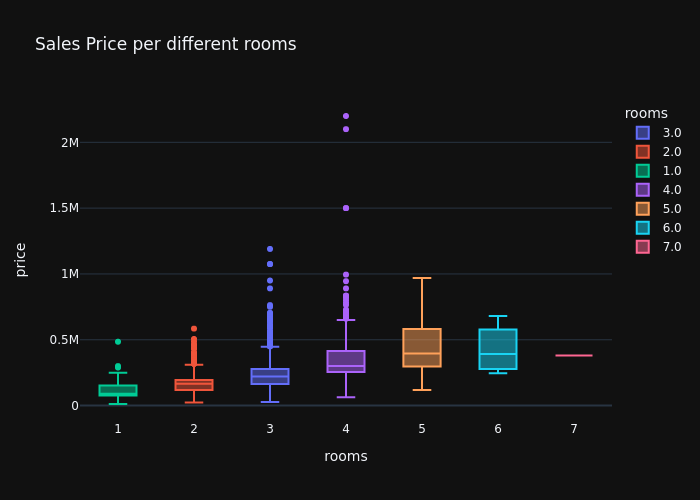

In [26]:
graph1 = px.box(df,x='rooms',y='price',color='rooms',template='plotly_dark',title=' Sales Price per different rooms')
graph1.show("png")

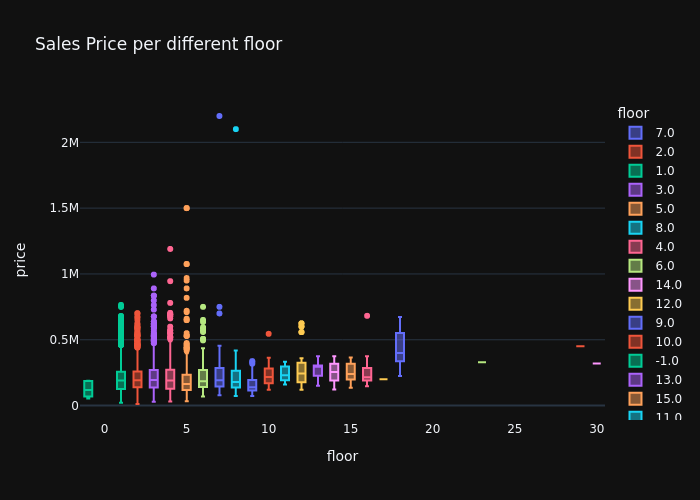

In [27]:
graph2=px.box(df,x='floor',y='price',color='floor',template='plotly_dark',title=' Sales Price per different floor')
graph2.show("png")

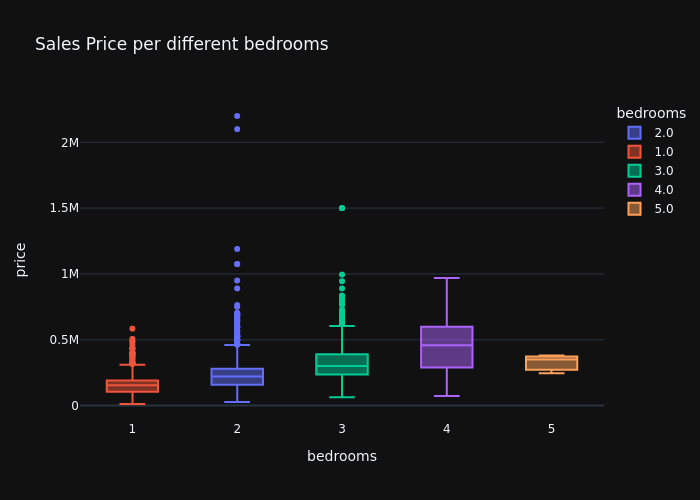

In [28]:
graph3= px.box(df,x='bedrooms',y='price',color='bedrooms',template='plotly_dark',title=' Sales Price per different bedrooms')
graph3.show("png")

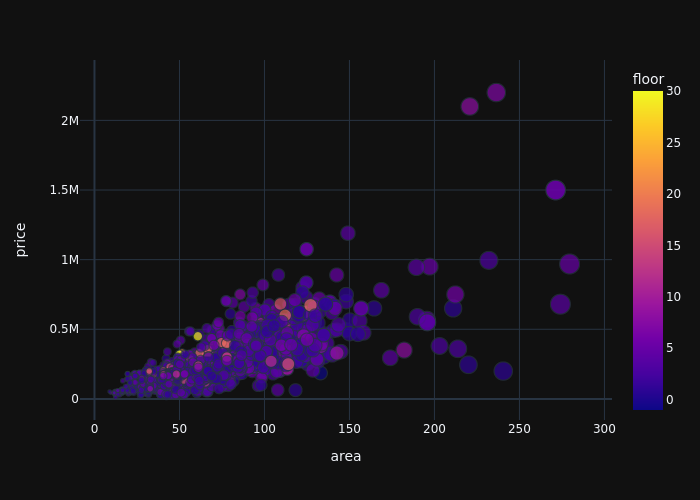

In [29]:
graph4= px.scatter(df,x='area',y='price',color='floor',size='area',template='plotly_dark')
graph4.show("png")

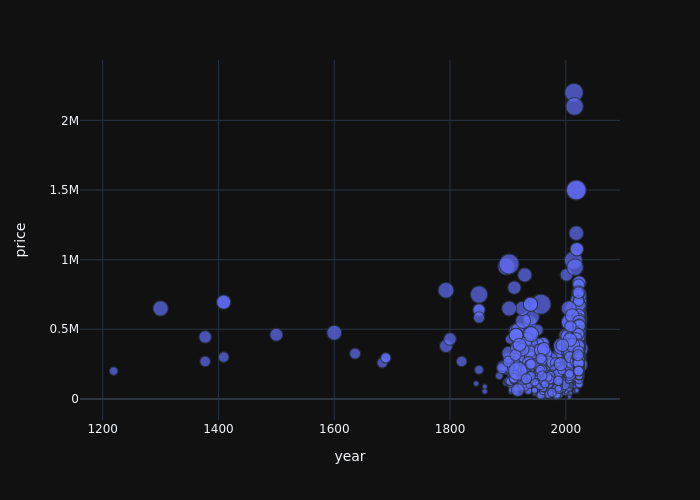

In [30]:
graph5 = px.scatter(df,x='year',y='price',size='area',template='plotly_dark')
graph5.show("png")

# Model

In [31]:
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler, OrdinalEncoder,OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_predict
from sklearn.pipeline import make_pipeline
import numpy as np

In [32]:
target_column = 'price'

In [33]:
categorical_cols = [c for c in df.columns if df[c].dtype in [object]]
numerical_cols = [c for c in df.columns if df[c].dtype in [float, int] and c not in [target_column]]
print("Categorical columns are: "+ ", ".join(categorical_cols))
print("Numerical columns are: "+ ", ".join(numerical_cols))

Categorical columns are: Date, energy_label, maakond
Numerical columns are: rooms, bedrooms, area, floor, total_floors, year, flag_balcony, flag_lift, flag_shower, flag_bath, flag_sauna, flag_generalheat, flag_floorheat, flag_gasheat, flag_electricalheat, flag_brick, flag_panel, flag_beton, flag_stone, flag_wood, flag_newbuilding, flag_indevelopment, flag_renovated, flag_needsrenovation


In [34]:
X = df[numerical_cols+categorical_cols]
y = df[target_column]

In [35]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
def cv(model, params):
    grid = GridSearchCV(model, params, scoring='neg_root_mean_squared_error', cv=5)
    grid.fit(X_train, y_train)
    print(grid.best_params_)
    return(grid.best_estimator_)

In [37]:
lgbm = LGBMRegressor()
params = {}
params['lgbmregressor__num_leaves'] = [7, 14, 21, 28, 31, 50]
params['lgbmregressor__max_depth'] = [-1, 3, 5, 8]
params['lgbmregressor__learning_rate'] = [0.15,0.1, 0.01, 0.001]
params['lgbmregressor__boosting_type'] = ['gbdt','dart','goss']


model = make_pipeline(ColumnTransformer([
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),    
    ]),
    lgbm)

In [38]:
best_model = cv(model,params)
best_model.fit(X_train, y_train)
preds = best_model.predict(X_test)
print("The RMSFE error is:", round(mean_squared_error(y_test,preds)**(1/2),2))
print("The R2 is:", round(r2_score(y_test, preds),2))

{'lgbmregressor__boosting_type': 'goss', 'lgbmregressor__learning_rate': 0.15, 'lgbmregressor__max_depth': -1, 'lgbmregressor__num_leaves': 31}
The RMSFE error is: 45872.87
The R2 is: 0.86


In [39]:
rf = RandomForestRegressor()
params = {}
params['randomforestregressor__max_depth'] = [1,5,15,30]
params['randomforestregressor__n_estimators'] = [10,50,100,150]
params['randomforestregressor__min_samples_split'] = [2,4,8]
params['randomforestregressor__max_features'] = ["auto", "sqrt", "log2"]
params['randomforestregressor__bootstrap'] = [True, False]

model = make_pipeline(ColumnTransformer([
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),    
    ]),rf
    )

In [40]:
best_model = cv(model,params)
best_model.fit(X_train, y_train)
preds = best_model.predict(X_test)
print("The RMSFE error is:", round(mean_squared_error(y_test,preds)**(1/2),2))
print("The R2 is:", round(r2_score(y_test, preds),2))

{'randomforestregressor__bootstrap': False, 'randomforestregressor__max_depth': 30, 'randomforestregressor__max_features': 'sqrt', 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 100}
The RMSFE error is: 43081.8
The R2 is: 0.87


In [41]:
lm = LinearRegression()
model = make_pipeline(ColumnTransformer([
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),    
    ]),lm
    )
model.fit(X_train,y_train)
preds = model.predict(X_test)
print("The RMSFE error is:", round(mean_squared_error(y_test,preds)**(1/2),2))
print("The R2 is:", round(r2_score(y_test, preds),2))

The RMSFE error is: 56938.3
The R2 is: 0.78
